In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context('notebook', font_scale=1.3)
sns.set_palette('tab10')
sns.set_style('white')

In [33]:
from glob import glob
import json
def rows():
    for fn in glob('../julia/runs/dingo/results/matched_rollouts*'):
        with open(fn) as f:
            d = json.load(f)
            for roll in d['matched_rollouts']:
                roll.update(d['params'])
                yield roll
df = pd.DataFrame(rows())

In [34]:
df['n_step'] = df.focused.apply(len)
df_value = np.stack(df.value)
df['value_max'] = df_value.max(1)
df['value_mean'] = df_value.mean(1)
df['value_std'] = df_value.std(1)
df['choice_value'] = df_value[np.arange(len(df)), df.choice.values - 1]

In [35]:
cutoff = df.n_step.quantile(0.99)
df = df.query('n_step < @cutoff').copy()
df['loss'] = df.value_max - df.choice_value
df['error'] = df.loss > 0
df['n_fix'] = df.focused.apply(lambda x: np.sum(np.diff(x) != 0) + 1)

import statsmodels.formula.api as smf
def ols(formula):
    return smf.ols(formula, data=df).fit().summary().tables[1]

In [66]:
belief = np.stack(df.belief)

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


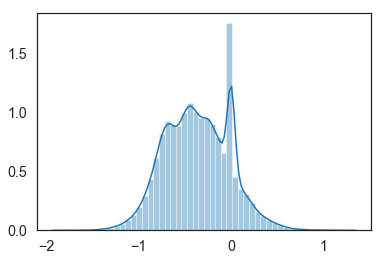

In [91]:
sns.distplot(belief.min(1))

In [90]:
neg = (belief < 0).all(1)
pos = (belief > 0).all(1)
print(belief[neg].min(1).mean())
print(belief[pos].min(1).mean())

-0.8584773408483818
0.1937311144433174


In [132]:
value = np.stack(df.value)

df['negative'] = (value < 0).all(1)
df['positive'] = (value > 0).all(1)

In [139]:
ols('value_std ~ value_mean')

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.8135,0.001,668.026,0.000,0.811,0.816
value_mean,0.2465,0.002,98.901,0.000,0.242,0.251


In [143]:
df.belief.apply(len)

0        2
1        2
2        2
3        2
4        2
5        2
6        2
7        2
8        2
9        2
10       2
11       2
12       2
13       2
14       2
15       2
16       2
17       2
18       2
19       2
20       2
21       2
22       2
23       2
24       2
25       2
26       2
27       2
28       2
29       2
        ..
59288    2
59290    2
59291    2
59292    2
59293    2
59295    2
59296    2
59297    2
59298    2
59299    2
59300    2
59301    2
59302    2
59303    2
59304    2
59305    2
59306    2
59307    2
59308    2
59309    2
59310    2
59311    2
59312    2
59313    2
59314    2
59315    2
59316    2
59317    2
59318    2
59319    2
Name: belief, Length: 57748, dtype: int64

In [118]:
def zscore(x):
    x = x - x.mean()
    x /= x.std()
    return x
    
print(ols('n_step ~ value_max'))

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.4063      0.129    173.631      0.000      22.153      22.659
value_max     -1.5951      0.104    -15.390      0.000      -1.798      -1.392


# Compare parameters

In [6]:
grp = df.groupby(['obs_sigma', 'sample_cost', 'switch_cost', 'seed'])[['n_step', 'reward', 'n_fix', 'choice_value']].mean()

In [1]:
# sns.catplot('obs_sigma', 'choice_value', row='sample_cost', col='switch_cost', data=grp.reset_index())

# Choose Parameters

In [43]:
hdf = pd.read_pickle('data/human_trials')
import h5py
hf = h5py.File('../data.h5')
value = np.array(hf.get('values'))
hf.close()
assert np.all(hdf.max_value == value.max(1))

from utils import Labeler
labeler = Labeler()
hdf['trial'] = [labeler(tuple(x)) for x in value]
df['trial'] = [labeler(tuple(x)) for x in df.value]

cutoff = hdf.rt.quantile(0.99)
drop = hdf.rt > cutoff
hdf = hdf.loc[~drop]

In [44]:
params = ['obs_sigma', 'sample_cost', 'switch_cost']
values = {k: list(df[k].unique()) for k in params}
for k, v in values.items():
    print(k, v)

obs_sigma [3.0, 5.0, 8.0]
sample_cost [0.001, 0.002, 0.003]
switch_cost [2.0, 3.0, 4.0, 8.0]


In [ ]:
def get_logp(mdf):
    d = mdf.groupby(['trial', 'choice']).apply(len)
    d /= d.sum(level=0)
    model_p = hdf.apply(lambda row: d[row.trial].get(row.choice, 0), axis=1)

    def log_likelihood(p_err):
        return np.log(model_p * (1 - p_err) + 1/3 * p_err).mean()

    ps = np.linspace(0, 0.05)
    logps = [log_likelihood(p) for p in ps]
    p_err = ps[np.argmax(logps)]
    return max(logps)

In [221]:
def get_mdf(obs_sigma, sample_cost, switch_cost):
    mdf = df.set_index(params).loc[obs_sigma, sample_cost, switch_cost]
    cutoff = mdf.n_step.quantile(0.99)
    mdf = mdf.query('n_step < @cutoff')
    time_per_step = hdf.rt.mean() / mdf.n_step.mean()
    print('seconds per step', time_per_step)
    mdf['rt'] = mdf.n_step * time_per_step
    return mdf

In [222]:
from utils import dict_product
from joblib import Parallel, delayed
def job(prm):
    print('-')
    mdf = get_mdf(**prm)
    logp = get_logp(mdf)
    r = {**prm, 'logp': logp}
    print(r)
    return r

# jobs = [delayed(job)(prm) for prm in dict_product(values)]
# result = Parallel(3)(jobs)

In [266]:
time_per_step = 84.66635603715173

In [223]:
MODEL_PARAMS = (5, 0.002, 8)
# fits = pd.DataFrame(result)
# MODEL_PARAMS = fits.set_index(params).logp.idxmax()
mdf = get_mdf(*MODEL_PARAMS)

seconds per step 84.66635603715173


/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [224]:
V = value[np.array(~drop)]
assert np.all(V.max(1) == hdf.value_max)

def softmax(x, temp=1):
    ex = np.exp((x - x.max(-1, keepdims=True)) / temp)
    return ex / ex.sum(-1, keepdims=True)

def log_likelihood(temp):
    P = softmax(V, temp)
    return np.log(P[np.arange(len(hdf)), hdf.choice.values - 1]).mean()

temps = np.linspace(0.2,5)
logps = [log_likelihood(t) for t in temps]
softmax_logp = max(logps)

In [225]:
baseline = np.log(1/3)
print(fits.logp.max())
print(softmax_logp)
print(baseline)

NameError: name 'fits' is not defined

# Plots

In [229]:
hdf['agent'] = 'Human'
mdf['agent'] = 'Model'

for dd in mdf, hdf:
    dd['loss'] = dd.value_max - dd.choice_value
    dd['error'] = dd.loss > 0


mdf['n_fix'] = mdf.focused.apply(lambda x: np.sum(np.diff(x) != 0) + 1)

# dd = pd.DataFrame([mdf.groupby('trial').n_step.mean()[trials], hdf.groupby('trial').rt.mean()]).T
# import statsmodels.formula.api as smf
# m = smf.ols('rt ~ n_step', data=dd).fit()
# m.summary()
# mdf['rt'] = m.predict(mdf.n_step)

tdf = pd.concat([hdf, mdf], sort=False).dropna(1)

In [230]:
def plot(func, data=tdf):
    g = sns.FacetGrid(data, col='agent')
    g.map_dataframe(func)
    g.set_titles('{col_name}')
    return g

def save(name):
    plt.tight_layout(pad=1.15)
    plt.savefig(f'figs/{name}.pdf')

## Choice quality

In [231]:
tdf.groupby('agent').choice_value.mean()

agent
Human    0.731801
Model    0.676865
Name: choice_value, dtype: float64

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


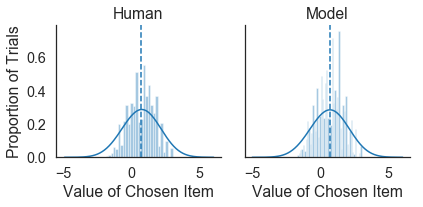

In [232]:
def f(data, **kwargs):
    sns.distplot(data.choice_value, kde_kws=dict(bw=1))
    plt.axvline(data.choice_value.mean(), ls='--')
    
plot(f).set_axis_labels('Value of Chosen Item', 'Proportion of Trials')
save('choice')

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


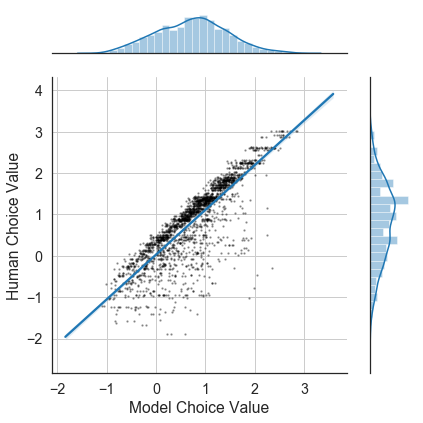

In [233]:
val = 'choice_value'
title = 'Choice Value'
x = tdf.groupby(['agent', 'trial'])[val].mean()
trials = x['Human'].index
model = x['Model'][trials]
human = x['Human']
g = sns.jointplot(model, human, kind='reg',  scatter=False)
plt.scatter(model, human, c='k', alpha=0.3, s=2)
plt.sca(g.ax_joint)
plt.xlabel(f'Model {title}')
plt.ylabel(f'Human {title}')
plt.grid()
save('joint_choice')

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


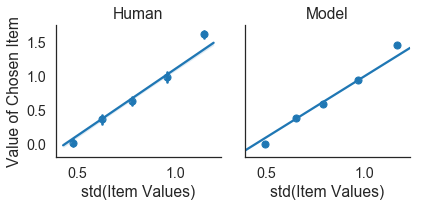

In [234]:
def f(data, **kwargs):    
    sns.regplot('value_std', 'choice_value', data=data, x_bins=5, ci=95)
#     plt.axhline(tdf.rt.mean(), ls='--')
plot(f).set_axis_labels('std(Item Values)', 'Value of Chosen Item')
save('choice_value')

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


NameError: name 'r' is not defined

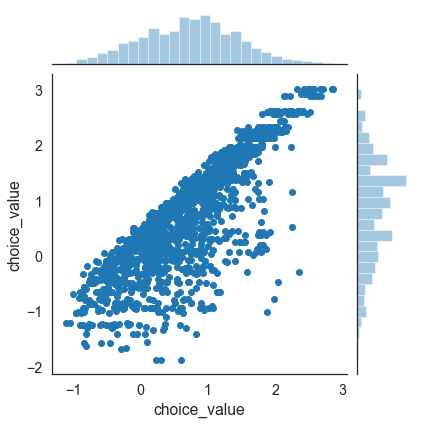

In [235]:
trial_value = tdf.groupby(['agent', 'trial']).choice_value.mean()
trials = trial_value['Human'].index
model = trial_value['Model'][trials]
human = trial_value['Human']
g = sns.jointplot(model, human)
g.ax_joint.text(-1, 2.8, f'r = {r:0.2f}  p < 1e-10', size=16)

## Number of fixations

In [ ]:
def n_fix(data, **kwargs):
    vc = data.n_fix.value_counts().sort_index()
    vc /= vc.sum()
    vc = vc.loc[1:10]
    vc.plot.bar(color='k')
    plt.xlabel('Number of Fixations')
    plt.ylabel('Proportion of Trials')

plot(n_fix).set_axis_labels('Number of Fixations', 'Proportion of Trials')
save('nfix')

## Reaction time

In [ ]:
g = tdf.groupby(['agent', 'trial']).rt.mean()
trials = g['Human'].index
model = g['Model'][trials]
human = g['Human']
g = sns.regplot(model, human, x_bins=5)
plt.axis('square')
plt.xlim(1900, 2800)
plt.ylim(1900, 2800)
plt.xlabel('Model RT')
plt.ylabel('Human RT')
plt.grid()
# g.ax_joint.text(-1, 2.8, f'r = {r:0.2f}  p < 1e-10', size=16)

In [ ]:
def f(data, **kwargs):
    sns.distplot(data.rt)
    plt.xlim(0, 10000)
    # plt.axvline(tdf.rt.mean(), ls='--')

plot(f).set_axis_labels('Reaction Time (s)', 'Proportion of Trials')
plt.tight_layout(pad=1.2)
save('rt')

In [ ]:
def f(data, **kwargs):    
    sns.regplot('value_std', 'rt', data=data, x_bins=5, ci=95)
#     plt.axhline(tdf.rt.mean(), ls='--')
plot(f).set_axis_labels('std(Item Values)', 'Reaction Time')
save('value_std')

In [ ]:
def f(data, **kwargs):    
    sns.regplot('value_mean', 'rt', data=data, x_bins=5, ci=95)
#     plt.axhline(tdf.rt.mean(), ls='--')
    
plot(f).set_axis_labels('mean(Item Values)', 'Reaction Time')
save('value_mean')

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


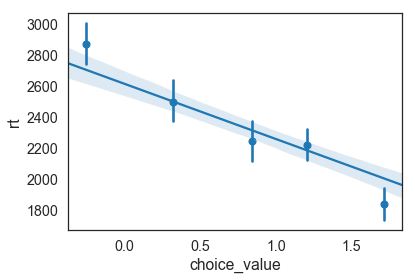

In [281]:
sns.regplot('choice_value', 'rt', data=hdf, x_bins=5)

In [298]:
tdf['relative_chosen'] = tdf.choice_value - tdf.value_mean

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


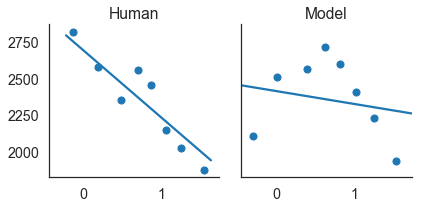

In [304]:
def f(data, **kwargs):
    sns.regplot('relative_chosen', 'rt', data=data, x_bins=8, ci=None)
    
plot(f)

## Attention

In [272]:
from toolz import concat

def focus_ranks(row):
    ranks = np.argsort(-np.array(row['value'])) + 1
    return ranks[np.array(row['focused'])-1]


model_ranks = pd.DataFrame(list(concat(enumerate(focus_ranks(row)) for i, row in mdf.iterrows())),
                     columns=['step', 'focus'])

In [273]:
human_ranks = pd.read_pickle('data/human_focus')
human_ranks.focus_rank = human_ranks.focus_rank.astype(int)
human_ranks['agent'] = 'Human'
model_ranks['agent'] = 'Model'
model_ranks['focus_rank'] = model_ranks.pop('focus')
model_ranks['time'] = model_ranks.pop('step') * time_per_step
ranks = pd.concat([human_ranks, model_ranks], sort=False)
ranks.head()

,time,focus_rank,agent
0,0.0,1,Human
0,50.0,1,Human
0,100.0,1,Human
0,150.0,1,Human
0,200.0,1,Human


In [ ]:
def f(data, **kwargs):
    n_step = data.groupby(['focus_rank', 'time']).apply(len)
    p_step = n_step / n_step.sum(level=1)
    p_step.unstack().T.plot(ax=plt.gca())
    max_x = (human_ranks.time.value_counts() > 100).argmin()
    plt.xlim(0,max_x)
    plt.axhline(1/3, c='k', lw=1, ls='--')
    plt.ylim(0, 0.5)
    plt.savefig('figs/human_fix.pdf')

g = plot(f, data=ranks)
g.set_axis_labels('Time', 'Probability of Fixating')
g.add_legend(title='Item Value Rank')
plt.subplots_adjust(bottom=0.2, left=0.15)
plt.savefig('figs/prob_fix.pdf')


In [ ]:
dd = pd.melt(pd.get_dummies(human_ranks, columns=['focus_rank']), id_vars=['time', 'agent'], var_name='rank', value_name='focused')
dd['rank'] = dd['rank'].str[-1]
sns.lmplot('time', 'focused', hue='rank', data=dd, scatter=False, )

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
mod = smf.glm('focused ~ time * rank', family=sm.families.Binomial(), data=dd)
mod.fit().summary()